#  <center> Representations of molecules <center>

## Graph Convolutional Nets 

In [ ]:
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem import Descriptors,Crippen
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import pandas as pd
import sys
import torch 
from tqdm import tqdm
import itertools

from rdkit import RDLogger   
RDLogger.DisableLog('rdApp.*') # turn off RDKit warning message 

### 1.1 Construct molecular graph datasets and dataloader

In [ ]:
import wget
wget.download( 'https://raw.githubusercontent.com/wwang2/ML4MolEng/master/psets/ps4/data/qm9.csv' )

100% [........................................................................] 30584525 / 30584525

'qm9 (3).csv'

In [ ]:
# implement SMILES to graph function  
def smiles2graph(smiles):
    '''
    Transfrom smiles into a list nodes (atomic number)
    
    Args: 
        smiles (str): SMILES strings
    
    return: 
        z(np.array), A (np.array): list of atomic numbers, adjancency matrix 
    '''
    
    mol = Chem.MolFromSmiles( smiles ) # no hydrogen 
    z = np.array( [atom.GetAtomicNum() for atom in mol.GetAtoms()] )
    A = np.stack(Chem.GetAdjacencyMatrix(mol))
    
    return z, A

In [ ]:
class GraphDataset(torch.utils.data.Dataset):
    def __init__(self,
                 AtomicNum_list, 
                 Edge_list, 
                 Natom_list, 
                 y_list):
        
        '''
        GraphDataset object
        
        Args: 
            z_list (list of torch.LongTensor)
            a_list (list of torch.LongTensor)
            N_list (list of int)
            y_list (list of torch.FloatTensor)

        '''
        self.AtomicNum_list = AtomicNum_list # atomic number
        self.Edge_list = Edge_list # edge list 
        self.Natom_list = Natom_list # Number of atoms 
        self.y_list = y_list # properties to predict 

    def __len__(self):
        return len(self.Natom_list)

    def __getitem__(self, idx):
        
        AtomicNum = torch.LongTensor(self.AtomicNum_list[idx])
        Edge = torch.LongTensor(self.Edge_list[idx])
        Natom = self.Natom_list[idx]
        y = torch.Tensor(self.y_list[idx])
        
        return AtomicNum, Edge, Natom, y

In [ ]:
def collate_graphs(batch):
    '''Batch multiple graphs into one batched graph
    
    Args:
    
        batch (tuple): tuples of AtomicNum, Edge, Natom and y obtained from GraphDataset.__getitem__() 
        
    Return 
        (tuple): Batched AtomicNum, Edge, Natom, y
    
    '''
    
    AtomicNum_batch = []
    Edge_batch = []
    Natom_batch = []
    y_batch = []

    cumulative_atoms = np.cumsum([0] + [b[2] for b in batch])[:-1]
    
    for i in range(len(batch)):
        z, a, N, y = batch[i]
        index_shift = cumulative_atoms[i]
        a = a + index_shift
        AtomicNum_batch.append(z) 
        Edge_batch.append(a)
        Natom_batch.append(N)
        y_batch.append(y)
        
    AtomicNum_batch = torch.cat(AtomicNum_batch)
    Edge_batch = torch.cat(Edge_batch, dim=1)
    Natom_batch = Natom_batch
    y_batch = torch.cat(y_batch)
    
    return AtomicNum_batch, Edge_batch, Natom_batch, y_batch 

In [ ]:
import torch
from sklearn.utils import shuffle

df = pd.read_csv("qm9.csv")
df = shuffle(df).reset_index()

AtomicNum_list = []
Edge_list = []
y_list = []
Natom_list = []

#y_list = list(df.loc[:,'alpha'].values)

for idx, smiles in enumerate(df.iloc[:,2]):
  z, A = smiles2graph(smiles)
  AtomicNum_list.append(z)
  A = A.nonzero()
  Edge_list.append(A)
  Natom_list.append(len(z))
  y_list.append( np.array([df.loc[idx,'alpha']]) )


In [ ]:
# Some conversions to tensors

AtomicNum_list = [torch.LongTensor(item) for item in AtomicNum_list]

Edge_list = [torch.LongTensor(item) for item in Edge_list]

#y_list = torch.FloatTensor(y_list)

y_list = [torch.FloatTensor(item) for item in y_list]


Make train, valdiation, test datasets and dataloaders

In [ ]:

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

X_data = []
for i in range(len(AtomicNum_list)):
  X_data.append([AtomicNum_list[i], Edge_list[i], Natom_list[i]])

# Split dataset to train/val/test ( Ratios: 0.8*0.875=0.7 / 0.8*0.125=0.1 / 0.2 )
X, X_test, y, y_test = train_test_split(X_data, y_list, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.125)

AtomicNum_train = []
Edge_train = []
Natom_train = []

for i in range(len(X_train)):
  AtomicNum_train.append(X_train[i][0])
  Edge_train.append(X_train[i][1])
  Natom_train.append(X_train[i][2])

AtomicNum_val = []
Edge_val = []
Natom_val = []

for i in range(len(X_val)):
  AtomicNum_val.append(X_val[i][0])
  Edge_val.append(X_val[i][1])
  Natom_val.append(X_val[i][2])

AtomicNum_test = []
Edge_test = []
Natom_test = []

for i in range(len(X_test)):
  AtomicNum_test.append(X_test[i][0])
  Edge_test.append(X_test[i][1])
  Natom_test.append(X_test[i][2])

graph_train = GraphDataset(AtomicNum_train, Edge_train, Natom_train, y_train)
graph_val = GraphDataset(AtomicNum_val, Edge_val, Natom_val, y_val)
graph_test = GraphDataset(AtomicNum_test, Edge_test, Natom_test, y_test)

# Build dataloader
batchsize = 512
train_loader = DataLoader(dataset=graph_train, batch_size=batchsize, shuffle=True, collate_fn=collate_graphs)
val_loader = DataLoader(dataset=graph_val, batch_size=batchsize, shuffle=True, collate_fn=collate_graphs)
test_loader = DataLoader(dataset=graph_test, batch_size=batchsize, shuffle=True, collate_fn=collate_graphs)


### 1.2 Set up GNN

In [ ]:
from itertools import repeat
def scatter_add(src, index, dim_size, dim=-1, fill_value=0):
    
    '''
    Sums all values from the src tensor into out at the indices specified in the index 
    tensor along a given axis dim. 
    '''
    
    index_size = list(repeat(1, src.dim()))
    index_size[dim] = src.size(dim)
    index = index.view(index_size).expand_as(src)
    
    dim = range(src.dim())[dim]
    out_size = list(src.size())
    out_size[dim] = dim_size

    out = src.new_full(out_size, fill_value)

    return out.scatter_add_(dim, index, src)

In [ ]:
from torch import nn
from torch.nn import ModuleDict

class GNN(torch.nn.Module):
    '''
        A GNN model 
    '''
    def __init__(self, n_convs=3, n_embed=64):
        super(GNN, self).__init__()
        self.atom_embed = nn.Embedding(100, n_embed)
        # Declare MLPs in a ModuleList
        self.convolutions = nn.ModuleList(
            [ 
                ModuleDict({
                    'update_mlp': nn.Sequential(nn.Linear(n_embed, n_embed), 
                                                nn.ReLU(), 
                                                nn.Linear(n_embed, n_embed)),
                    'message_mlp': nn.Sequential(nn.Linear(n_embed, n_embed), 
                                                 nn.ReLU(), 
                                                 nn.Linear(n_embed, n_embed)) 
                })
                for _ in range(n_convs)
            ]
            )
        # Declare readout layers
        self.readout = nn.Sequential(nn.Linear(n_embed, n_embed), nn.ReLU(), nn.Linear(n_embed, 1))

    def forward(self, AtomicNum, Edge, Natom):
        
        # Parametrize embedding 
        h = self.atom_embed(AtomicNum) #eqn. 1

        i = Edge[0]
        j = Edge[1]

        for conv in self.convolutions:
          
          hij = h[i] * h[j]
          message_i2j = conv["message_mlp"](hij)

          node_message = scatter_add(src=message_i2j, index=Edge[1], dim=0, dim_size=len(AtomicNum))
                       #+ scatter_add(src=message_i2j, index=Edge[0], dim=0, dim_size=len(AtomicNum))

          h = h + conv["update_mlp"](node_message)

        h_split = self.readout(h)
        output = torch.stack([torch.sum(split) for split in torch.split(h_split, Natom)], dim=0)
        
        return output

### 1.3 Verify permutational invariance

In [ ]:
def permute_graph(z, a, perm):
    '''
        permute the order of nodes in a molecular graph 
        
        Args: 
            z(np.array): atomic number array
            a(np.array): edge index pairs 
            
        Return: 
            (np.array, np.array): permuted atomic number, and edge list 
    '''
    
    z = np.array(z)
    perm = np.array(perm)
    assert len(perm) == len(z)
    
    z_perm = z[perm]
    a_perm = np.zeros(a.shape).astype(int)
    
    for i, edge in enumerate(a):
        for j in range(len(edge)):
            a_perm[i, j] = np.where(perm==edge[j])[0]
    return z_perm, a_perm

# node input
AtomicNum_orig = np.array([6, 6, 8, 7])
# edge input 
Edge_orig = np.array([[0, 0, 1, 2, 3, 0], [1, 2, 0, 0, 0, 3]] )
# generate permutations
permutation = itertools.permutations([0, 1 ,2, 3])

Test your model on permuted graph

In [ ]:
#print(AtomicNum_train[0])
#print(Edge_train[0])

device = 0
model = GNN(n_convs=4, n_embed=128).to(device)
model.eval()


for perm in permutation:
  
  perm_graph = permute_graph(AtomicNum_orig, Edge_orig, perm)

  perm_AtomicNum = torch.LongTensor(perm_graph[0]).to(device)
  perm_Edge = torch.LongTensor(perm_graph[1]).to(device)
  perm_Natom = len(perm_graph[0])
  output = model(perm_AtomicNum, perm_Edge, perm_Natom)
  output = output.detach().cpu().numpy().flatten()
  np.set_printoptions(precision=5)
  print("model output: {} for perumutation: {}".format(output, perm)) 

model output: [-1.32977] for perumutation: (0, 1, 2, 3)
model output: [-1.32977] for perumutation: (0, 1, 3, 2)
model output: [-1.32977] for perumutation: (0, 2, 1, 3)
model output: [-1.32977] for perumutation: (0, 2, 3, 1)
model output: [-1.32977] for perumutation: (0, 3, 1, 2)
model output: [-1.32977] for perumutation: (0, 3, 2, 1)
model output: [-1.32977] for perumutation: (1, 0, 2, 3)
model output: [-1.32977] for perumutation: (1, 0, 3, 2)
model output: [-1.32977] for perumutation: (1, 2, 0, 3)
model output: [-1.32977] for perumutation: (1, 2, 3, 0)
model output: [-1.32977] for perumutation: (1, 3, 0, 2)
model output: [-1.32977] for perumutation: (1, 3, 2, 0)
model output: [-1.32977] for perumutation: (2, 0, 1, 3)
model output: [-1.32977] for perumutation: (2, 0, 3, 1)
model output: [-1.32977] for perumutation: (2, 1, 0, 3)
model output: [-1.32977] for perumutation: (2, 1, 3, 0)
model output: [-1.32977] for perumutation: (2, 3, 0, 1)
model output: [-1.32977] for perumutation: (2, 3

### 1.4  Train and evaluate GNN

In [ ]:
from torch import optim

optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=10, verbose=True)

In [ ]:
def loop(model, loader, epoch, evaluation=False):
    
    if evaluation:
        model.eval()
        mode = "eval"
    else:
        model.train()
        mode = 'train'
    batch_losses = []
    
    # Define tqdm progress bar 
    tqdm_data = tqdm(loader, position=0, leave=True, desc='{} (epoch #{})'.format(mode, epoch))
    
    for data in tqdm_data:
        
        AtomicNumber, Edge, Natom, y = data 
        AtomicNumber = AtomicNumber.to(device)
        Edge = Edge.to(device)
        y = y.to(device)
        
        # make predictions 
        pred = model(AtomicNumber, Edge, Natom)
        
        # define loss 
        loss = (pred-y).pow(2).mean()  
        
        if not evaluation:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        batch_losses.append(loss.item())

        postfix = ['batch loss={:.3f}'.format(loss.item()) , 
                   'avg. loss={:.3f}'.format(np.array(batch_losses).mean())]
        
        tqdm_data.set_postfix_str(' '.join(postfix))
    
    return np.array(batch_losses).mean()

In [ ]:
import os

# Get the current working directory
mydrive = os.getcwd()

model2 = GNN(n_convs=3, n_embed=64).to(device)

from torch import optim

optimizer = optim.Adam(model2.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=50, verbose=True)

train_l = []
val_l = []
ep = []

for epoch in range(50):    
    train_loss = loop(model2, train_loader, epoch)
    val_loss = loop(model2, val_loader, epoch, evaluation=True)
    
    ep.append(epoch)
    train_l.append(train_loss)
    val_l.append(val_loss)

    # save model 
    if epoch % 10 == 0:
        torch.save(model.state_dict(), "{}/gcn_model_{}.pt".format(mydrive, epoch))

eval (epoch #49): 100%|██████████████████████████████| 27/27 [00:01<00:00, 18.28it/s, batch loss=4.013 avg. loss=4.871]


Scatter plots and loss

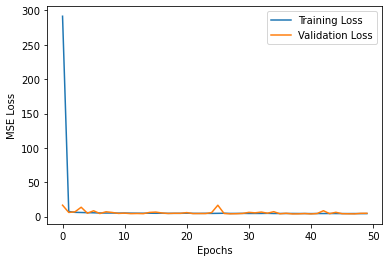

In [ ]:
import matplotlib.pyplot as plt

plt.plot(ep, train_l)
plt.plot(ep, val_l)
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

In [ ]:

model.eval()
mode = "eval"

# Get prediction for training set
tqdm_data = tqdm(train_loader, position=0, leave=True, desc='{} (epoch #{})'.format(mode, 1))

y_pred_train = []
y_true_train = []

for data in tqdm_data:
  
  AtomicNum_train, Edge_train, Natom_train, y_true = data
  AtomicNum_train = AtomicNum_train.to(device)
  Edge_train = Edge_train.to(device)
  # make predictions 
  prediction_train = model2(AtomicNum_train, Edge_train, Natom_train)

  y_pred_train.append(prediction_train.detach().cpu().numpy().flatten())
  y_true_train.append(y_true.detach().cpu().numpy().flatten())

# Get prediction for test set
tqdm_data = tqdm(test_loader, position=0, leave=True, desc='{} (epoch #{})'.format(mode, 1))

y_pred_test = []
y_true_test = []

for data in tqdm_data:
  
  AtomicNum_test, Edge_test, Natom_test, y_true = data
  AtomicNum_test = AtomicNum_test.to(device)
  Edge_test = Edge_test.to(device)
  # make predictions 
  prediction_test = model2(AtomicNum_test, Edge_test, Natom_test)

  y_pred_test.append(prediction_test.detach().cpu().numpy().flatten())
  y_true_test.append(y_true.detach().cpu().numpy().flatten())


eval (epoch #1): 100%|█████████████████████████████████████████████████████████████████| 53/53 [00:02<00:00, 20.67it/s]


In [ ]:
pred_train = [item for sublist in y_pred_train for item in sublist]
true_train = [item for sublist in y_true_train for item in sublist]

pred_test = [item for sublist in y_pred_test for item in sublist]
true_test = [item for sublist in y_true_test for item in sublist]

eval (epoch #1): 100%|███████████████████████████████| 53/53 [00:02<00:00, 18.20it/s, batch loss=4.522 avg. loss=5.238]


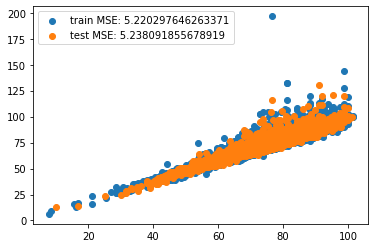

In [ ]:

train_loss = loop(model2, train_loader, 1, evaluation=True)

plt.scatter(pred_train, true_train, label='train MSE: {}'.format(train_loss))

test_loss = loop(model2, test_loader, 1, evaluation=True)

plt.scatter(pred_test, true_test, label='test MSE: {}'.format(test_loss))

plt.legend()
plt.show()


Caption: The scatter plot shows the polarizability values from the model (x-axis) vs the ground truth (y-axis), for the training (blue) and testing (orange) splits of the dataset.